[[ 0.05215356  0.05215356  0.05215356 ...  0.05215356 -0.05215356
   0.05215356]
 [ 0.05732418  0.05732418  0.05732418 ...  0.05732418 -0.05732418
   0.05732418]
 [ 0.06297336  0.06297336  0.06297336 ...  0.06297336 -0.06297336
   0.06297336]
 ...
 [ 0.85814894  0.85814894  0.85814894 ...  0.85814894 -0.85814894
   0.85814894]
 [ 0.86989153  0.86989153  0.86989153 ...  0.86989153 -0.86989153
   0.86989153]
 [ 0.88079708  0.88079708  0.88079708 ...  0.88079708 -0.88079708
   0.88079708]]
(50, 1000)


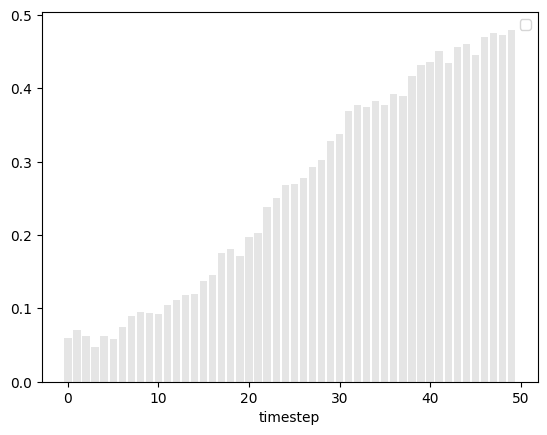

/usr/local/lib/python3.10/dist-packages/pymc/data.py:317: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymc/data.py:317: FutureWarning: MutableData is deprecate

In [4]:
# %%
import pymc as pm
import numpy as np
import arviz as az
import random as rm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from typing import Callable
import numpy.typing as npt
import graphviz


includeIrrelevantFeatures = True
includeNoise=True
environmentData = dict()
abilityMax = {
    "navigationAbility": 5.3,
    "visualAbility": 1.9,
}
abilityMin = {
    "navigationAbility": 0,
    "visualAbility": 0,
}
def rbf_kernel(X, length_scale=1.0):
    """
    Generates a covariance matrix using the RBF (squared exponential) kernel.

    Parameters:
    X (numpy.ndarray): The input data, a 1D array of points.
    length_scale (float): The length scale parameter for the RBF kernel.

    Returns:
    numpy.ndarray: The covariance matrix.
    """
    # Calculate the pairwise squared Euclidean distances
    sq_dists = np.subtract.outer(X, X) ** 2

    # Compute the covariance matrix using the RBF kernel
    K = np.exp(-sq_dists / (2 * length_scale ** 2))

    return K

def margin(a, b):
  return a - b

def scaledBeta(name, a, b, min, max, shape):

  beta = pm.Beta(f"{name}_raw", a, b, shape = shape)
  print(beta.shape)
  return pm.Deterministic(name, beta * (max - min) + min)

def setupModel(taskResults, cholesky):
    m = pm.Model()
    assert taskResults.shape == (T, N)
    with m:
      ### Environment Variables as Deterministic
      demands_distance = pm.MutableData("rewardDistance", environmentData["reward_distance"])
      demands_size = pm.MutableData("rewardSize", environmentData["reward_size"])
      demands_behind = pm.MutableData("rewardBehind", environmentData["reward_behind"])

      # Priors
      if includeNoise:
        sigma_performance = pm.Uniform("sigma_noise", lower=0, upper=1)
      else:
        rightLeftEffect = pm.Deterministic("rightLeftEffect", 0)
      sigma_vis = pm.HalfNormal("sigma_vis", sigma=1.0)
      sigma_nav = pm.HalfNormal("sigma_nav", sigma=1.0)
      sigma_bias = pm.HalfNormal("sigma_bias", sigma=1.0)
      ability_visual = pm.GaussianRandomWalk("ability_visual", mu = 0, sigma = sigma_vis, shape = T)
      ability_nav = pm.GaussianRandomWalk("ability_navigation", mu = 0, sigma = sigma_nav, shape = T)

      if (includeIrrelevantFeatures) :
        ability_bias_rl = pm.GaussianRandomWalk("ability_bias_rl", mu = 0, sigma = sigma_bias, shape = T)                  # [-inf,inf] A parameter to determine whether left or right have an influence. It's expected to be zero, but negative would be left influence and positive a right influence (or vice versa :-)
        abilityMin["rightLeftBias"] = -np.inf
        abilityMax["rightLeftBias"] = np.inf

        demands_xpos = pm.MutableData("Xpos", environmentData["Xpos"])  #

      if (includeIrrelevantFeatures) :
        rightLeftEffect = pm.Deterministic("rightLeftEffect", product_on_time_varying(ability_bias_rl, demands_xpos))
      else :
        rightLeftEffect = 0

      # Performance

      navigation_performance = pm.Deterministic("navigation_performance", logistic(performance_from_capability_and_demand_batch(ability_nav, demands_distance*(1/2 * demands_behind + 1)) + rightLeftEffect))
      visual_performance = pm.Deterministic("visual_performance", logistic(performance_from_capability_and_demand_batch(ability_visual, demands_size)))
      task_performance = pm.Bernoulli("task_performance", p=(1 - sigma_performance)*(navigation_performance*visual_performance) + sigma_performance*1, observed=taskResults)
    return m

def setupModelSingle(taskResults):
  m = pm.Model()
  with m:
      ### Environment Variables as Deterministic
      rewardDistance = pm.MutableData("rewardDistance", environmentData["reward_distance"])
      rewardSize = pm.MutableData("rewardSize", environmentData["reward_size"])
      rewardBehind = pm.MutableData("rewardBehind", environmentData["reward_behind"])

      ### priors
      navigationAbility = scaledBeta("navigationAbility", 1,1, abilityMin["navigationAbility"], abilityMax["navigationAbility"])
      visualAbility = scaledBeta("visualAbility", 1, 1, abilityMin["visualAbility"], abilityMax["visualAbility"])


      if (includeIrrelevantFeatures) :
        rightLeftBias = pm.Normal("rightLeftBias", 0,1)                  # [-inf,inf] A parameter to determine whether left or right have an influence. It's expected to be zero, but negative would be left influence and positive a right influence (or vice versa :-)
        abilityMin["rightLeftBias"] = -np.inf
        abilityMax["rightLeftBias"] = np.inf

        XPos = pm.MutableData("Xpos", environmentData["Xpos"])  #


        if (includeIrrelevantFeatures) :
          rightLeftEffect = pm.Deterministic("rightLeftEffect", rightLeftBias * XPos)
        else :
          rightLeftEffect = pm.Deterministic("rightLeftEffect", 0)

      ##Performance
      #navigationP = pm.Deterministic("navigationP", logistic(margin(navigationAbility, rewardDistance)))
      navigationP = pm.Deterministic("navigationP", logistic(margin(navigationAbility, rewardDistance*(rewardBehind*0.5+1.0)) + rightLeftEffect))  # Including rewardBehind (multiplies by 1.5 if behind) and rightLeftEffect
      visualP = pm.Deterministic("visualP", logistic(margin(visualAbility, rewardSize)))


      if includeNoise :
        # noise = 0.5 # Works almost perfectly, except for the perfect model
        noise = 1 - np.mean(taskResults)  # With this noise is complementary to result prior.
        # pm.Uniform("noise", 0, 1) # Doesn't work because it can just adjust this to be 1 or 0 for perfect or worst agents even if there's no noise
        # noise= random.uniform(0.0, 1.0) # Not sure it will generate a value each time.
        #noise= pm.Bernoulli("noise", np.mean(taskResults))  # This would generate values either 0 and 1 with the prior of taskResults
        noiseLevel = pm.Uniform("noiseLevel", 0, 1)
        abilityMax["noiseLevel"] = 1
        abilityMin["noiseLevel"] = 0
        finalP = pm.Deterministic("finalP", (1-noiseLevel)*navigationP*visualP + (noiseLevel*noise))
        taskPerformance=pm.Bernoulli("taskPerformance", finalP, observed=taskResults)
      else:
        taskPerforamnce = pm.Bernoulli("taskPerformance",  navigationP * visualP, observed = taskResults)
  return m

def logistic(x):
    return 1 / (1 + np.exp(-x))



T = 50  # number of time steps
N = 1000  # number of samples
performance_from_capability_and_demand_batch: Callable[[npt.ArrayLike,npt.ArrayLike], npt.ArrayLike] = lambda capability, demand : (capability[:,None]-demand)
product_on_time_varying: Callable[[npt.ArrayLike,npt.ArrayLike], npt.ArrayLike] = lambda capability, demand : (capability[:,None]*demand)
np.random.seed(0)
learn_time_nav = 0.5*T
learn_time_vis = 0.2*T
learn_time_bias = 0.3*T
time_steps = np.linspace(1, T, T)
covar_matrix = rbf_kernel(time_steps, length_scale = 10)
cholesky_matrix = np.linalg.cholesky(covar_matrix + np.eye(T)*0.0000001)
capability_nav = logistic((time_steps - learn_time_nav)/(T/5))*5.3 #particular point where significant learning occurs, and rate at which this is is determined by the denominator
capability_vis = logistic((time_steps - learn_time_vis)/(T/5))*1.9
capability_bias = logistic((time_steps- 30)/(T/5))
# Task capability creation, representing a range of arenas
np.random.seed(0)
# Task capability creation, representing a range of arenas
behind = np.random.choice([0, 0.5, 1], N) # 0 if in front of agent's front facing direction, 0.5 if l/r of agent's front facing direction, 1 if behind agent's front facing direction
distance = np.random.uniform(0.1, 5.3, N)
environmentData["reward_distance"] = distance
environmentData["reward_behind"] = behind
# distance = np.random.uniform(0, 5.3, N)
xpos = np.random.choice([-1, 0, 1], N) # -1 if l of agent's actual position, 0 if in line with agent's actual position, 1 if r of agent's actual position
reward_size = np.random.uniform(0, 1.9, N)
environmentData["reward_size"] = reward_size
environmentData["Xpos"] = xpos

rightlefteffect_ = product_on_time_varying(capability_bias, xpos)
print(rightlefteffect_)
perf_nav = logistic(performance_from_capability_and_demand_batch(capability_nav, distance*(behind*0.5+1.0)) + rightlefteffect_)
perf_vis = logistic(performance_from_capability_and_demand_batch(capability_vis, reward_size))
successes = np.random.binomial(1, perf_nav*perf_vis, (T, N)) == 1
print(successes.shape)
# Visualise the true values of the data
prop_successes = np.mean(successes, axis=1)
plt.bar(range(T), prop_successes, color="grey", alpha=0.2)
plt.xlabel("timestep")
plt.legend()
plt.show()

m = setupModel(successes, cholesky_matrix)





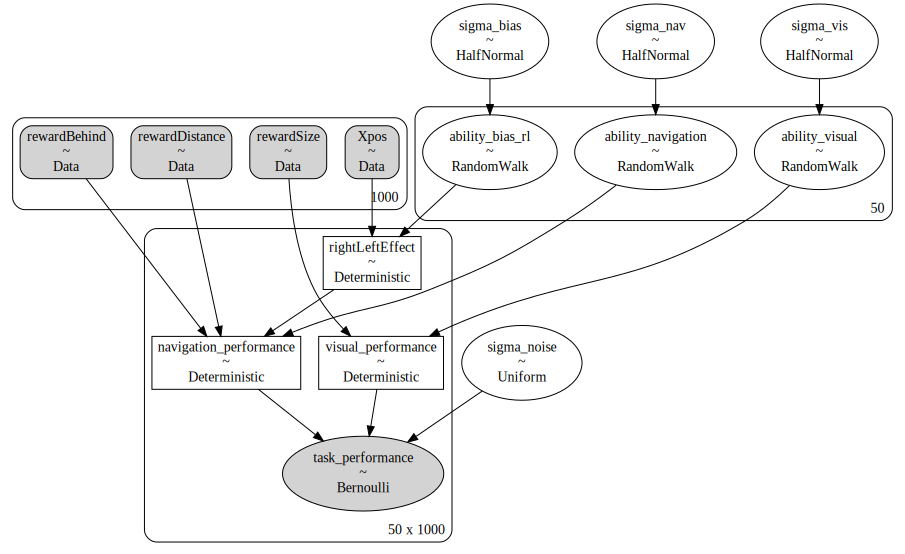

In [5]:
gv = pm.model_graph.model_to_graphviz(m)
gv

In [6]:
with m:
        inference_data = pm.sample(500, target_accept=0.95, cores=2)


for cap, true_mus in [("rightLeftBias", capability_bias)]:
    estimated_p_per_ts = inference_data["posterior"][f"{cap}"].mean(dim=["chain", "draw"])
    # TODO: Understand the hdi function a bit more (why does this 'just work'?)
    estimate_hdis = az.hdi(inference_data["posterior"][f"{cap}"], hdi_prob=0.95)[f"ability_{cap}"]
    low_hdis = [l for l,_ in estimate_hdis]
    high_hdis = [u for _,u in estimate_hdis]
    plt.plot(range(T), true_mus, label=f"True capability {cap} value")
    # TODO: Is it justified to do sigmoid of the mean?
    plt.plot([e for e in estimated_p_per_ts], label="estimated", color="grey")
    # TODO: how does the hdi change after transformation through a sigmoid?
    plt.fill_between([i for i in range(T)], [l for l in low_hdis], [h for h in high_hdis], color="grey", alpha=0.2)
    plt.xlabel("timestep")
    plt.legend()
    plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Visualise the true values of the data
for cap, true_mus in [("navigation", capability_nav), ("visual", capability_vis), ("bias_rl", capability_bias)]:
    ax1.plot(range(T), true_mus)
    estimated_p_per_ts = inference_data["posterior"][f"ability_{cap}"].mean(dim=["chain", "draw"])
    # TODO: Understand the hdi function a bit more (why does this 'just work'?)
    estimate_hdis = az.hdi(inference_data["posterior"][f"ability_{cap}"], hdi_prob=0.95)[f"ability_{cap}"]
    low_hdis = [l for l,_ in estimate_hdis]
    high_hdis = [u for _,u in estimate_hdis]

    ax2.plot([e for e in estimated_p_per_ts], label="estimated")



Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


KeyError: "No variable named 'rightLeftBias'. Variables on the dataset include ['chain', 'draw', 'ability_bias_rl_dim_0', 'ability_bias_rl', 'ability_navigation_dim_0', ..., 'sigma_noise', 'sigma_vis', 'visual_performance_dim_0', 'visual_performance_dim_1', 'visual_performance']"

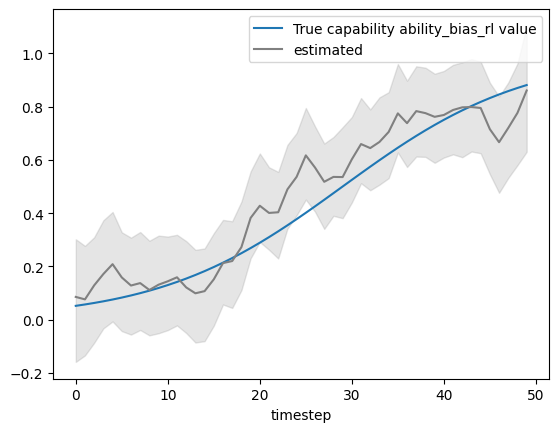

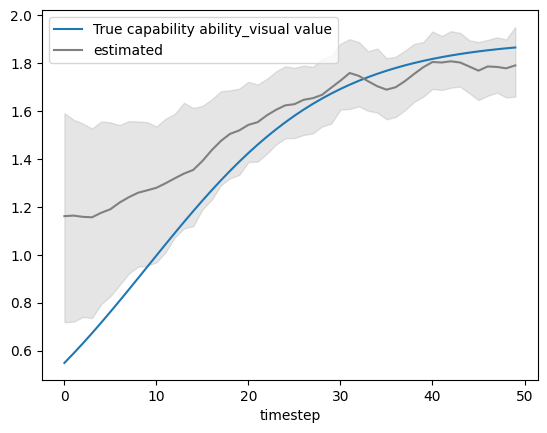

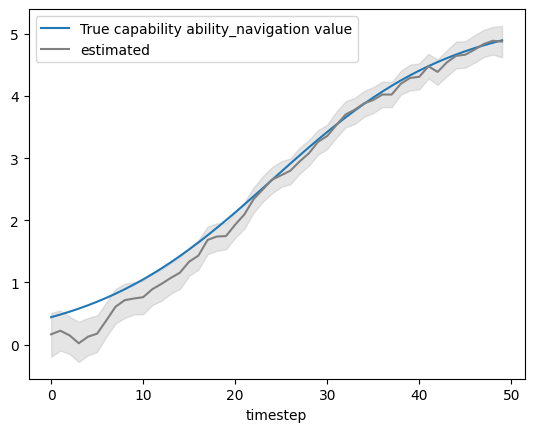

In [7]:
for cap, true_mus in [("ability_bias_rl", capability_bias), ("ability_visual", capability_vis), ("ability_navigation", capability_nav)]:
    estimated_p_per_ts = inference_data["posterior"][f"{cap}"].mean(dim=["chain", "draw"])
    # TODO: Understand the hdi function a bit more (why does this 'just work'?)
    estimate_hdis = az.hdi(inference_data["posterior"][f"{cap}"], hdi_prob=0.95)[f"{cap}"]
    low_hdis = [l for l,_ in estimate_hdis]
    high_hdis = [u for _,u in estimate_hdis]
    plt.plot(range(T), true_mus, label=f"True capability {cap} value")
    # TODO: Is it justified to do sigmoid of the mean?
    plt.plot([e for e in estimated_p_per_ts], label="estimated", color="grey")
    # TODO: how does the hdi change after transformation through a sigmoid?
    plt.fill_between([i for i in range(T)], [l for l in low_hdis], [h for h in high_hdis], color="grey", alpha=0.2)
    plt.xlabel("timestep")
    plt.legend()
    plt.show()

In [ ]:
m.debug()

point={'sigma_noise_interval__': array(0.), 'ability_visual_raw_logodds__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'ability_navigation_raw_logodds__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 

In [ ]:
# prompt: plot the posterior of the bias_rl value
az.plot_posterior(inference_data["posterior"]["ability_bias_rl"])
print(capability_bias)

KeyError: "No variable named 'ability_bias_rl'. Variables on the dataset include ['chain', 'draw', 'navigationAbility', 'navigationAbility_raw', 'navigationP_dim_0', ..., 'rightLeftEffect', 'visualAbility', 'visualAbility_raw', 'visualP_dim_0', 'visualP']"